In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve,accuracy_score,classification_report

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from pandasql import sqldf

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.dummy import DummyClassifier
import scipy.stats as st

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

plt.rcParams['figure.figsize'] = (8, 5)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

In [2]:
df = pd.read_csv('data.csv')

In [3]:
x = df[['country', 'year', 'uniqueid', 'location_type',
       'cellphone_access', 'household_size', 'age_of_respondent',
       'gender_of_respondent', 'relationship_with_head', 'marital_status',
       'education_level', 'job_type']]


y = df[['bank_account']]

x_tr, x_test, y_tr, y_test = train_test_split(x, y,test_size=.25, random_state=12)

In [4]:
x_tr['is_urban'] = np.where(x_tr['location_type'] == 'Urban',1,0)
x_tr['cellphone'] = np.where(x_tr['cellphone_access'] == 'Yes',1,0)
x_tr['is_male'] = np.where(x_tr['gender_of_respondent'] == 'Male',1,0)
x_tr['is_youth'] = np.where(x_tr['age_of_respondent'] <= 35,1,0)
x_tr['hh_5'] = np.where(x_tr['household_size'] <= 5,1,0)

<ipython-input-4-88c8f1b9bbf0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr['is_urban'] = np.where(x_tr['location_type'] == 'Urban',1,0)
<ipython-input-4-88c8f1b9bbf0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr['cellphone'] = np.where(x_tr['cellphone_access'] == 'Yes',1,0)
<ipython-input-4-88c8f1b9bbf0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [5]:
x_tr_cont = x_tr[['year','hh_5','is_youth','is_urban','cellphone','is_male']]
x_tr_cat = x_tr[['country','relationship_with_head', 'marital_status','education_level', 'job_type']]

In [6]:
# Regroup to reduce number of categories
x_tr_cat.loc[x_tr_cat['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
x_tr_cat.loc[x_tr_cat['education_level'] == 'Other/Dont know/RTA', ['education_level']] = 'No formal education'
x_tr_cat.loc[x_tr_cat['job_type'] == 'Dont Know/Refuse to answer', ['job_type']] = 'No Income'
x_tr_cat.loc[x_tr_cat['relationship_with_head'] == 'Other non-relatives', ['relationship_with_head']] = 'Other relative'

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-6-fd79ac22a8b3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr_cat.loc[x_tr_cat['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
<ipython-input-6-fd79ac22a8b3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

In [7]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(x_tr_cat)

ohe_x_train = ohe.transform(x_tr_cat)

columns = ohe.get_feature_names(['county',
                                 'relationship_with_head', 
                                 'marital_status',
                                 'education_level', 
                                 'job_type'])

ohe_x_tr_df = pd.DataFrame(ohe_x_train, columns=columns, index=x_tr.index)

In [8]:
combo_train_df = pd.concat([x_tr_cont, ohe_x_tr_df], axis=1)

In [9]:
# Create dummy variable for bank account
y_tr['bank_acc'] = np.where(y_tr['bank_account'] == 'Yes', 1,0)

<ipython-input-9-b1430f2c33c5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_tr['bank_acc'] = np.where(y_tr['bank_account'] == 'Yes', 1,0)


In [10]:
x_train, x_val, y_train, y_val = train_test_split(combo_train_df, y_tr, test_size=.20, random_state=11)

In [11]:
y_train.drop(columns='bank_account',inplace=True)
y_val.drop(columns='bank_account',inplace=True)

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


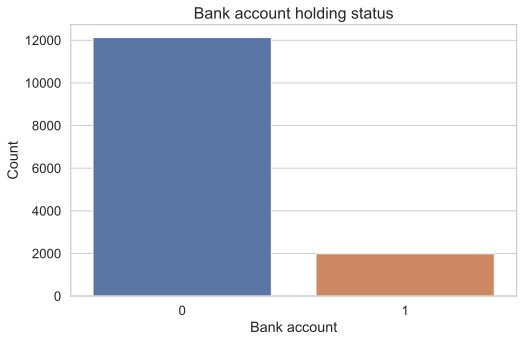

In [12]:
sns.countplot(x='bank_acc', data=y_train)
plt.title('Bank account holding status',family='arial',fontsize=16)
plt.xlabel('Bank account')
plt.ylabel('Count')
plt.show;

In [13]:
count_no_acc = len(y_train[y_train['bank_acc']==0])
count_acc = len(y_train[y_train['bank_acc']==1])
pct_of_no_acc = count_no_acc/(count_no_acc+count_acc)
print("percentage of no account:", pct_of_no_acc*100)
pct_of_acc = count_acc/(count_no_acc+count_acc)
print("percentage of account", pct_of_acc*100)

percentage of no account: 85.9288649567805
percentage of account 14.071135043219499


Classes are __very imbalanced__ - investigate threshold, over and undersampling

In [14]:
df_train = pd.concat([x_train,y_train],axis=1)
df_val = pd.concat([x_val,y_val],axis=1)

## Naive Bayes

All features, no interactions

In [15]:
features = ['year', 'hh_5', 'is_youth', 'is_urban', 'cellphone', 'is_male',
       'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Other relative',
       'relationship_with_head_Parent', 'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Other Income', 'job_type_Remittance Dependent',
       'job_type_Self employed']

In [16]:
nb = BernoulliNB()
nb.fit(df_train[features],df_train['bank_acc'])
print('Accuracy of Naive Bayes classifier on val set: {:.3f}'.format(
    nb.score(df_val[features],df_val['bank_acc'])))

Accuracy of Naive Bayes classifier on val set: 0.874


In [17]:
y_pred = nb.predict(df_val[features])
print(confusion_matrix(df_val['bank_acc'],y_pred))

[[2881  156]
 [ 288  204]]


In [18]:
print(classification_report(df_val['bank_acc'],y_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      3037
           1       0.57      0.41      0.48       492

    accuracy                           0.87      3529
   macro avg       0.74      0.68      0.70      3529
weighted avg       0.86      0.87      0.87      3529



In [19]:
df_val['proba_bank'] = nb.predict_proba(df_val[features])[:, 1]

fpr1, tpr1, thresholds1 = roc_curve(df_val['bank_acc'],
                                 df_val['proba_bank'])

In [20]:
def plot_roc(true, probas,fpr,tpr):
    auc = roc_auc_score(true, probas)

    plt.plot(fpr, tpr, marker='o')
    plt.xlabel('1 - Specificity (FPR)')
    plt.ylabel('Sensitivity (TPR)');
    plt.title(f"Area Under the ROC Curve: {round(auc, 3)}");

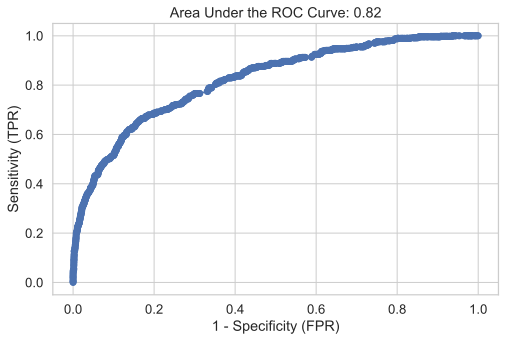

In [21]:
plot_roc(df_val['bank_acc'], df_val['proba_bank'],fpr1,tpr1)

Pretty good. However, while F1 score is better for Naive Bayes than logistic regression, there is slightly higher ROC AUC for logistic regression

## Adding female hh interaction

In [22]:
df_train_2 = df_train.copy()
df_val_2 = df_val.copy()

df_train_2['female_hh'] = np.where((df_train_2['is_male'] == 0) & 
                                   (df_train_2['relationship_with_head_Head of Household']==1),1,0)

df_val_2['female_hh'] = np.where((df_val_2['is_male'] == 0) & 
                                 (df_val_2['relationship_with_head_Head of Household']==1),1,0)

In [23]:
features2 = ['year', 'hh_5', 'is_youth', 'is_urban', 'cellphone', 'is_male',
       'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Other relative',
       'relationship_with_head_Parent', 'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Other Income', 'job_type_Remittance Dependent',
       'job_type_Self employed','female_hh']

In [24]:
nb2 = BernoulliNB()
nb2.fit(df_train_2[features2],df_train_2['bank_acc'])
print('Accuracy of Naive Bayes classifier on val set: {:.3f}'.format(
    nb2.score(df_val_2[features2],df_val_2['bank_acc'])))

Accuracy of Naive Bayes classifier on val set: 0.874


## Dropping primary education

In [25]:
features3 = ['year', 'hh_5', 'is_youth', 'is_urban', 'cellphone', 'is_male',
       'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Other relative',
       'relationship_with_head_Parent', 'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Other Income', 'job_type_Remittance Dependent',
       'job_type_Self employed','female_hh']

In [26]:
df_train_3 = df_train_2.drop(columns=['education_level_Primary education'],axis=1)
df_val_3= df_val_2.drop(columns=['education_level_Primary education'],axis=1)

In [27]:
nb3 = BernoulliNB()
nb3.fit(df_train_3[features3],df_train_3['bank_acc'])
print('Accuracy of Naive Bayes classifier on val set: {:.3f}'.format(
    nb3.score(df_val_3[features3],df_val_3['bank_acc'])))

Accuracy of Naive Bayes classifier on val set: 0.882


## Dropping self employed

In [28]:
features4 = ['year', 'hh_5', 'is_youth', 'is_urban', 'cellphone', 'is_male',
       'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Parent', 'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'relationship_with_head_Other relative',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Other Income', 'job_type_Remittance Dependent','female_hh']

In [29]:
df_train_4 = df_train_3.drop(columns=['job_type_Self employed'],axis=1)
df_val_4= df_val_3.drop(columns=['job_type_Self employed'],axis=1)

In [30]:
nb4 = BernoulliNB()
nb4.fit(df_train_4[features4],df_train_4['bank_acc'])
print('Accuracy of Naive Bayes classifier on val set: {:.3f}'.format(
    nb4.score(df_val_4[features4],df_val_4['bank_acc'])))

Accuracy of Naive Bayes classifier on val set: 0.882


## Dropping other income

In [31]:
features5 = ['year', 'hh_5', 'is_youth', 'is_urban', 'cellphone', 'is_male',
       'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Parent', 'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'relationship_with_head_Other relative',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
        'job_type_Remittance Dependent','female_hh']

In [32]:
df_train_5 = df_train_4.drop(columns=['job_type_Other Income'],axis=1)
df_val_5= df_val_4.drop(columns=['job_type_Other Income'],axis=1)

In [33]:
nb5 = BernoulliNB()
nb5.fit(df_train_5[features5],df_train_5['bank_acc'])
print('Accuracy of Naive Bayes classifier on val set: {:.3f}'.format(
    nb5.score(df_val_5[features5],df_val_5['bank_acc'])))

Accuracy of Naive Bayes classifier on val set: 0.881


In [34]:
y_pred5 = nb5.predict(df_val_5[features5])
print(confusion_matrix(df_val['bank_acc'],y_pred))

[[2881  156]
 [ 288  204]]


In [35]:
print(classification_report(df_val_5['bank_acc'],y_pred5))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      3037
           1       0.63      0.37      0.46       492

    accuracy                           0.88      3529
   macro avg       0.77      0.67      0.70      3529
weighted avg       0.87      0.88      0.87      3529



In [36]:
df_val_5['proba_bank'] = nb5.predict_proba(df_val_5[features5])[:, 1]

fpr5, tpr5, thresholds5 = roc_curve(df_val_5['bank_acc'],
                                 df_val_5['proba_bank'])

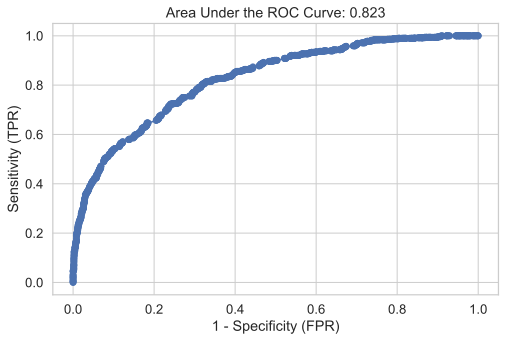

In [37]:
plot_roc(df_val_5['bank_acc'], df_val_5['proba_bank'],fpr5,tpr5)

In [52]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

In [53]:
precision5, recall5, thresholds_5 = precision_recall_curve(df_val['bank_acc'], df_val['proba_bank'])

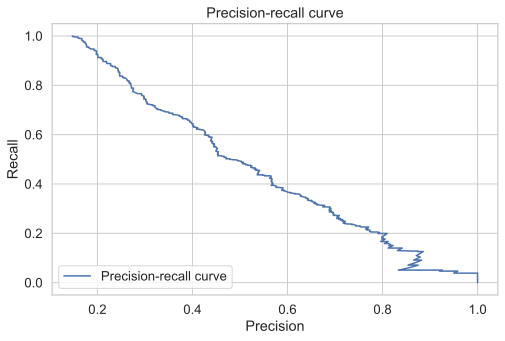

In [54]:
plt.plot(precision5, recall5, label='Precision-recall curve')
_ = plt.xlabel('Precision')
_ = plt.ylabel('Recall')
_ = plt.title('Precision-recall curve')
_ = plt.legend(loc="lower left")

In [55]:
auc5 = auc(recall5, precision5)
auc5

0.5215820314603087

Only a minor improvement from the first nb model

## Testing the model on the test set

Note the first analysis is based on the first multiple regression model above (including all features, no interactions)

1. Preparing the test sample 

In [38]:
x_test['is_urban'] = np.where(x_test['location_type'] == 'Urban',1,0)
x_test['cellphone'] = np.where(x_test['cellphone_access'] == 'Yes',1,0)
x_test['is_male'] = np.where(x_test['gender_of_respondent'] == 'Male',1,0)
x_test['is_youth'] = np.where(x_test['age_of_respondent'] <= 35,1,0)
x_test['hh_5'] = np.where(x_test['household_size'] <= 5,1,0)

<ipython-input-38-b57eb4bc7d75>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['is_urban'] = np.where(x_test['location_type'] == 'Urban',1,0)
<ipython-input-38-b57eb4bc7d75>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['cellphone'] = np.where(x_test['cellphone_access'] == 'Yes',1,0)
<ipython-input-38-b57eb4bc7d75>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [39]:
x_test_cont = x_test[['year','hh_5','is_youth','is_urban','cellphone','is_male']]
x_test_cat = x_test[['country','relationship_with_head', 'marital_status','education_level', 'job_type']]

In [40]:
x_test_cat.loc[x_test_cat['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
x_test_cat.loc[x_test_cat['education_level'] == 'Other/Dont know/RTA', ['education_level']] = 'No formal education'
x_test_cat.loc[x_test_cat['job_type'] == 'Dont Know/Refuse to answer', ['job_type']] = 'No Income'
x_test_cat.loc[x_test_cat['relationship_with_head'] == 'Other non-relatives', ['relationship_with_head']] = 'Other relative'

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-40-c58a8d9a8085>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test_cat.loc[x_test_cat['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
<ipython-input-40-c58a8d9a8085>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

In [41]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(x_test_cat)

ohe_x_test = ohe.transform(x_test_cat)

columns = ohe.get_feature_names(['county','relationship_with_head', 'marital_status',
       'education_level', 'job_type'])

ohe_x_test_df = pd.DataFrame(ohe_x_test, columns=columns, index=x_test.index)

In [42]:
combo_test_df = pd.concat([x_test_cont, ohe_x_test_df], axis=1)

In [43]:
y_test['bank_acc'] = np.where(y_test['bank_account'] == 'Yes', 1,0)
y_test.drop(columns='bank_account',inplace=True)
df_test = pd.concat([combo_test_df,y_test],axis=1)

<ipython-input-43-52765b19127d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['bank_acc'] = np.where(y_test['bank_account'] == 'Yes', 1,0)
/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Testing on nb model 5

In [44]:
df_test5 = df_test.drop(columns=['education_level_Primary education',
                                 'job_type_Other Income',
                                 'job_type_Self employed'],axis=1)

In [45]:
df_test5['female_hh'] = np.where((df_test5['is_male'] == 0) & 
                                   (df_test5['relationship_with_head_Head of Household']==1),
                                  1,0)

In [46]:
print('Accuracy of Naive Bayes classifier on val set: {:.3f}'.format(
    nb5.score(df_test5[features5],df_test5['bank_acc'])))

Accuracy of Naive Bayes classifier on val set: 0.877


In [47]:
y_pred5_test = nb5.predict(df_test5[features5])
print(confusion_matrix(df_test5['bank_acc'],y_pred5_test))

[[4840  207]
 [ 517  317]]


In [48]:
print(classification_report(df_test5['bank_acc'],y_pred5_test))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      5047
           1       0.60      0.38      0.47       834

    accuracy                           0.88      5881
   macro avg       0.75      0.67      0.70      5881
weighted avg       0.86      0.88      0.86      5881



In [49]:
df_test5['proba_bank'] = nb5.predict_proba(df_test5[features5])[:, 1]

fpr5_t, tpr5_t, thresholds5_t = roc_curve(df_test5['bank_acc'],
                                 df_test5['proba_bank'])

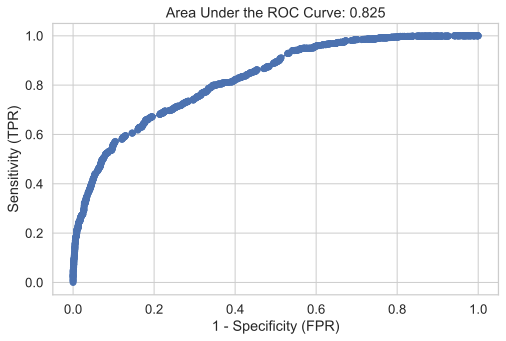

In [50]:
plot_roc(df_test5['bank_acc'], df_test5['proba_bank'],fpr5_t,tpr5_t)

Consistent performance on val and test - not over or underfitting

In [51]:
df_test5.head()

,year,hh_5,is_youth,is_urban,cellphone,is_male,county_Rwanda,county_Tanzania,county_Uganda,relationship_with_head_Head of Household,...,education_level_Vocational/Specialised training,job_type_Formally employed Government,job_type_Formally employed Private,job_type_Government Dependent,job_type_Informally employed,job_type_No Income,job_type_Remittance Dependent,bank_acc,female_hh,proba_bank
16628,2017,1,1,0,1,0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0.081970
12261,2016,0,0,0,1,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.047027
1101,2018,1,1,1,1,1,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0.923189
20899,2017,1,1,0,1,1,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.483399
7521,2016,1,1,1,1,0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0.773930


## How do I check which it is predicting well versus not? Same for logisitic regression